In [1]:
import py
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def log_files_to_df(client_log, indexer_log, nodes_log):
    indexer_log = py.path.local(indexer_log).read_text("utf-8") if indexer_log else None
    client_log = py.path.local(client_log).read_text("utf-8")
    nodes_log = py.path.local(nodes_log).read_text("utf-8") if nodes_log else None

    def parse_lines_with_pat(lines, pattern, numerical_cols):
        lines = [line for line in lines.split("\n")]
        parsed_lines = [re.match(pattern, line) for line in lines]
        parsed_lines = [line.groupdict() for line in parsed_lines if line]
    
        inner_df = pd.DataFrame.from_records(parsed_lines)
        
        for col in numerical_cols:
            inner_df[col] = inner_df[col].astype(int)
        
        return inner_df
    
    if nodes_log:
        certified_pat = r"Certified checkpoint (?P<cp_id>\d+) slowness (?P<certified_cp_lag>\d+) cp_ts \d+ certified_ts (?P<certified_cp_ts>\d+)"
        certified_parsed_df = parse_lines_with_pat(nodes_log, certified_pat, ['cp_id', 'certified_cp_lag', 'certified_cp_ts'])
    else:
        certified_parsed_df = None
    
    if indexer_log:
        fetch_pat = r"Remote fetched checkpoint (?P<cp_id>\d+) from (?P<cp_ts>\d+) timestamp: (?P<fetch_timestamp>\d+) slowness: \d+"
        fetch_parsed_df = parse_lines_with_pat(indexer_log, fetch_pat, ['cp_id', 'cp_ts', 'fetch_timestamp'])
    else:
        fetch_parsed_df = None
    
    if indexer_log:
        commit_pat = r"Committed checkpoint (?P<cp_id>\d+) from (?P<cp_ts>\d+) timestamp: (?P<commit_timestamp>\d+) slowness: \d+"
        commit_parsed_df = parse_lines_with_pat(indexer_log, commit_pat, ['cp_id', 'cp_ts', 'commit_timestamp'])
    else:
        commit_parsed_df = None
    
    pat = r"Test: (?P<test_name>[^\s]+) request_start_ts: (?P<request_start_ts>\d+) Tx_cp: (?P<cp_id>\d+) cp_ts: (?P<cp_ts>\d+) checkpoint created after: (?P<cp_lag>\d+) started waiting after: (?P<wait_lag>\d+) Wait Elapsed: (?P<wait_elapsed>\d+) Total request time: (?P<total_request_time>\d+)"
    df = parse_lines_with_pat(client_log, pat, ['request_start_ts', 'cp_id', 'cp_ts', 'cp_lag', 'wait_lag', 'wait_elapsed', 'total_request_time'])
    
    if certified_parsed_df is not None:
        certified_parsed_df = certified_parsed_df.set_index(['cp_id'])
        certified_parsed_df = certified_parsed_df.groupby("cp_id").max() # eliminate multiple entries for each cp
    if fetch_parsed_df is not None:
        fetch_parsed_df = fetch_parsed_df.set_index(['cp_id']).drop("cp_ts", axis=1)
    if commit_parsed_df is not None:
        commit_parsed_df = commit_parsed_df.set_index(['cp_id'])
    df = df.set_index(['cp_id'])
    
    if fetch_parsed_df is not None:
        indexer_df = fetch_parsed_df.join(commit_parsed_df, how="left")
        indexer_df = indexer_df.groupby(indexer_df.index).max()
        assert indexer_df.groupby(indexer_df.index).count().max().max() == 1 # ensure that there are no duplicate rows
    else:
        indexer_df = None

    if indexer_df is not None:
        joined_df = df.join(indexer_df.drop("cp_ts", axis=1), how="left")
        joined_df["indexer_fetch_lag"] = joined_df["fetch_timestamp"] - joined_df["request_start_ts"]
        joined_df["indexer_processing_duration"] = joined_df["commit_timestamp"] - joined_df["fetch_timestamp"]
        joined_df = joined_df.join(certified_parsed_df, how="left")
        joined_df["certified_cp_lag"] = joined_df["certified_cp_ts"] - joined_df["cp_ts"]
        joined_df = joined_df.drop(["fetch_timestamp", "commit_timestamp", "cp_ts", "certified_cp_ts"], axis=1)
    else:
        joined_df = df

    return joined_df

def experiment_data_dfs_to_plottable_df(experiment_data_dfs):
    joined_df = pd.concat(experiment_data_dfs)

    def quantile_agg(x, alpha=0.2, aggregate=pd.Series.mean):
        return aggregate(x[(x.quantile(alpha/2) < x) & (x < x.quantile(1 - alpha/2))])
    
    mean_df = joined_df.groupby("test_name").apply(quantile_agg)
    mean_df['request_started'] = 0

    df2 = mean_df.reindex([
        "test_transfer_object_fullnode",
        "test_transfer_object_indexer",
        "test_increment_counter_private_fullnode",
        "test_increment_counter_private_indexer",
        "test_increment_counter_public_fullnode",
        "test_increment_counter_public_indexer",
        "test_numerous_increments_counter_private_fullnode",
        "test_numerous_increments_counter_private_indexer",
        "test_numerous_increments_counter_public_fullnode",
        "test_numerous_increments_counter_public_indexer",
        "test_hit_the_hive_private_node",
        "test_hit_the_hive_private_indexer",
        "test_hit_the_hive_public_node",
        "test_hit_the_hive_public_indexer",
    ])
    
    df2.index = df2.index.map(lambda n: n
                  .replace("test_transfer_object", "Simple Transfer")
                  .replace("_fullnode", " - Fullnode")
                  .replace("_node", " - Fullnode")
                  .replace("_indexer", " - Indexer")
                  .replace("test_increment_counter", "Simple Move Call")
                  .replace("test_numerous_increments_counter", "Large PTB")
                  .replace("test_hit_the_hive", "Large Output")
                  .replace("_private", " - Owned Object")
                  .replace("_public", " - Shared Object")
                 )

    return df2

In [3]:
request_wait_time_color = "seagreen"
effects_wait_time_color = "lightgreen"
cp_certification_color = "black"
indexing_color = "darkgoldenrod"

def plot_df(df, xticks, title):
    fig, ax = plt.subplots(figsize=(10,6))

    n = 0
    certification_time_as_dots = False
    for index, row in df.iterrows():
        if index.endswith("Indexer"):
            plt.axhspan(n + 0.7, n + 1.7, facecolor='grey', alpha=0.5)
        rects = ax.broken_barh(xranges=[(row['request_started'], row['wait_lag']), (row['wait_lag'], row['wait_elapsed'])], yrange=(n + 0.85, 0.75),
                       color=[request_wait_time_color, effects_wait_time_color])
        
        if 'certified_cp_lag' in row:
            ax.broken_barh(xranges=[(row['indexer_fetch_lag'], row['indexer_processing_duration'])], yrange=(n + 1.05, 0.35), color=[indexing_color])
            ax.broken_barh(xranges=[(row['cp_lag'], row['certified_cp_lag'])], yrange=(n + 1.1, 0.25), color=[cp_certification_color])
        elif 'cp_lag' in row:
            # no certification duration available, only cp creation time
            certification_time_as_dots = True
            ax.plot(row['cp_lag'], n + 1.05 + 0.35/2, drawstyle='steps-post', marker='o', color=cp_certification_color, linewidth=3)
        n += 1

    ax.set_yticks([n + 1.25 for (n, _) in enumerate(df.index)])
    ax.set_yticklabels(df.index)

    handles = [
        mpatches.Patch(color=request_wait_time_color, label="Waiting for execute_transaction_block to complete"),
        mpatches.Patch(color=effects_wait_time_color, label="Waiting for TX effects to be visible in ReadApi"),
    ]

    if certification_time_as_dots:
        handles.append(mpatches.Patch(color=cp_certification_color, label="Checkpoint Creation"))
    else:
        handles.extend([
            mpatches.Patch(color=cp_certification_color, label="Time from Checkpoint creation to Checkpoint certification"),
            mpatches.Patch(color=indexing_color, label="Time from Checkpoint being fetched to the indexer to DB commit"),
        ])
    
    plt.legend(handles=handles, loc='lower center', ncol=1, bbox_to_anchor=(-0.15, 1))
    
    plt.xticks(xticks)

    plt.title(title)
    plt.xlabel("Time [ms]")
    
    plt.show()

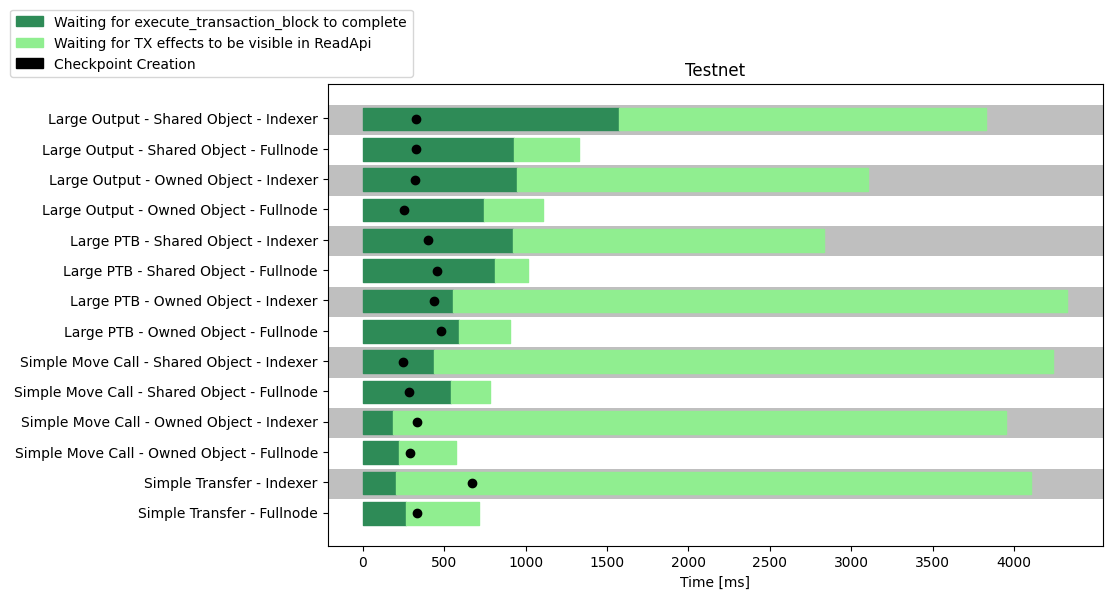

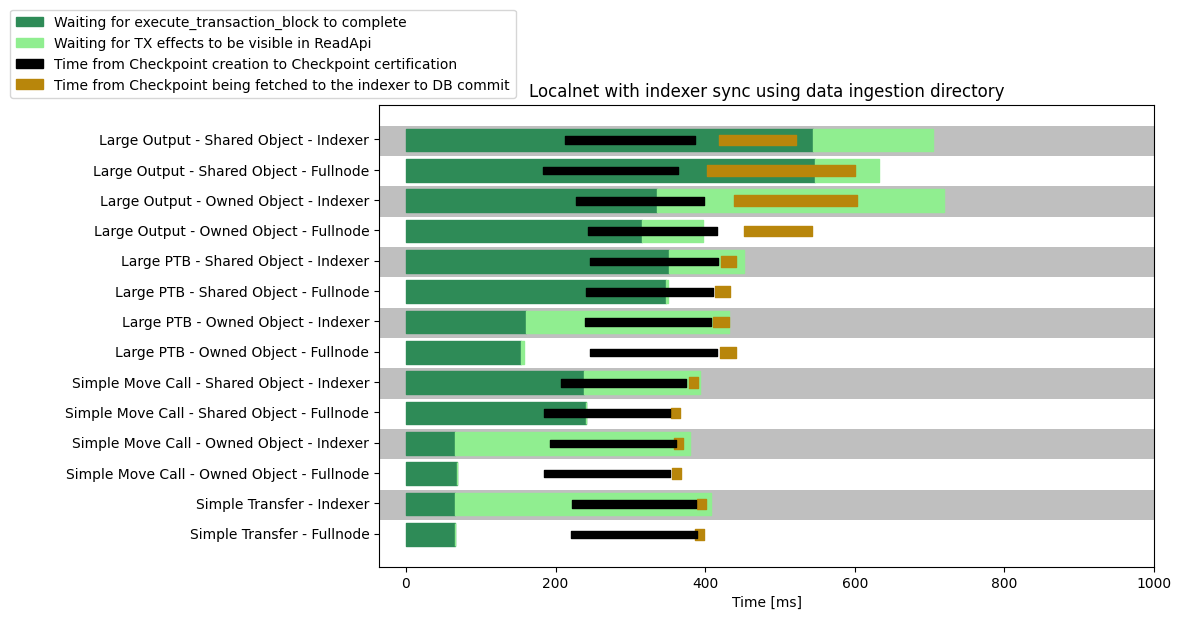

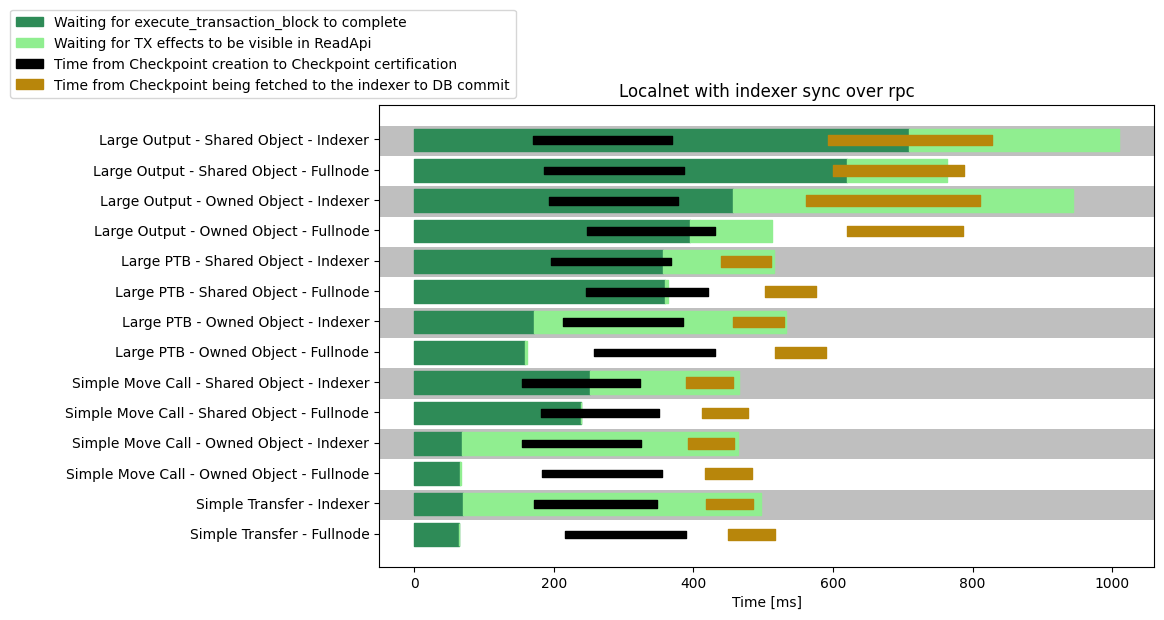

In [4]:
testnet_df = log_files_to_df("./results/new/client_testnet.log", None, None)
plot_df(experiment_data_dfs_to_plottable_df([testnet_df]), range(0, 4100, 500), "Testnet")

di_dir_df = log_files_to_df("./results/new/client_di_dir.log",
                            "./results/new/indexer_di_dir.log",
                            "./results/new/node_di_dir.log")
plot_df(experiment_data_dfs_to_plottable_df([di_dir_df]), range(0, 1200, 200), "Localnet with indexer sync using data ingestion directory")


rpc_method_df = log_files_to_df("./results/new/client_rpc_method.log",
                                "./results/new/indexer_rpc_method.log",
                                "./results/new/node_rpc_method.log")
rpc_method_df_2 = log_files_to_df("./results/new/client_rpc_method_2.log",
                                  "./results/new/indexer_rpc_method_2.log",
                                  "./results/new/node_rpc_method_2.log")
rpc_method_df_3 = log_files_to_df("./results/new/client_rpc_method_3.log",
                                  "./results/new/indexer_rpc_method_3.log",
                                  "./results/new/node_rpc_method_3.log")
plot_df(experiment_data_dfs_to_plottable_df([rpc_method_df, rpc_method_df_2, rpc_method_df_3]), range(0, 1200, 200), "Localnet with indexer sync over rpc")


In [5]:
def quantile_agg(x, alpha=0.2, aggregate=pd.Series.mean):
    return aggregate(x[(x.quantile(alpha/2) < x) & (x < x.quantile(1 - alpha/2))])
(
    testnet_df[["cp_lag"]].apply(quantile_agg),
    pd.concat([di_dir_df, rpc_method_df, rpc_method_df_2, rpc_method_df_3])[["cp_lag"]].apply(quantile_agg),
)

(cp_lag    363.125
 dtype: float64,
 cp_lag    201.878557
 dtype: float64)